# **Sentence Transformers**

In [1]:
# USING repo tagged prompts for now
import json
with open('../parse_data/repo_to_prompts.json', 'r') as f:
    data = json.load(f)

all_prompts = []
for repo in data.keys():
    all_prompts.extend(data[repo])

NOTE: Prompts are color-coded by the repos they are from.

/home/dpaul/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1127, 384)
(1127, 2)


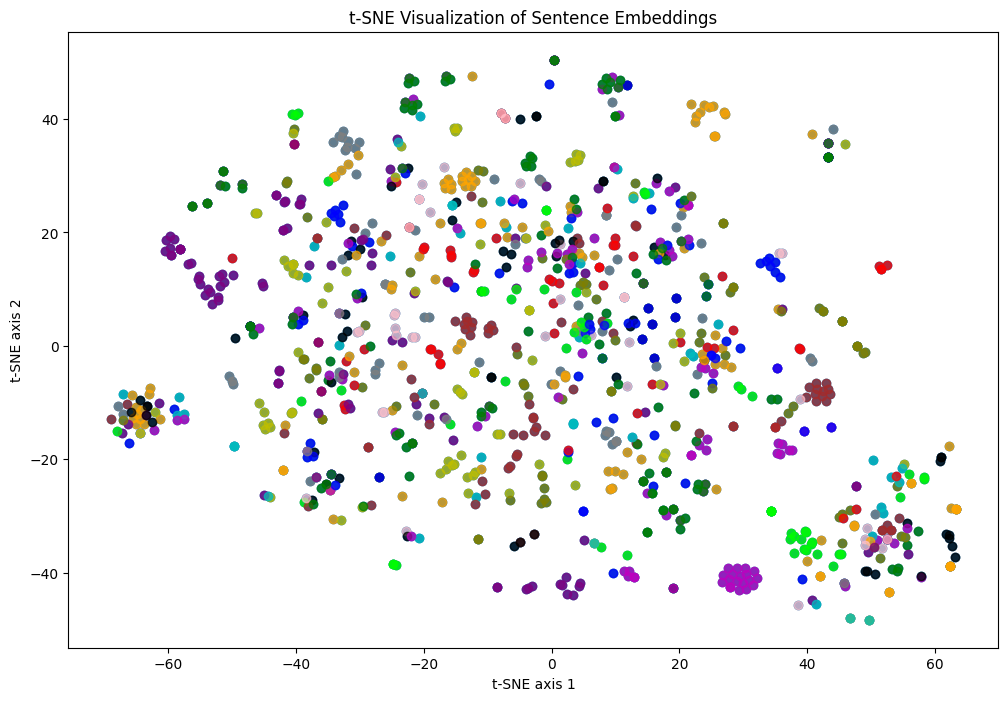

In [2]:
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import numpy as np

# Your list of strings
##############################################################################################################
# Flatten the list of strings and create a corresponding list of colors
# Colors for each repo
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'lime', 'brown', 'pink', 'gray', 'olive']
all_strings = []
color_map = []
for repo_index, (repo, strings) in enumerate(data.items()):
    all_strings.extend(strings)
    # Wrap around the color list since there are more repos than colors
    color_map.extend([colors[repo_index % len(colors)]] * len(strings))
##############################################################################################################

# Step 1: Generate Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(all_strings)
embeddings = np.array(embeddings)
print(embeddings.shape)

# Step 2: Reduce Dimensionality with t-SNE
tsne = TSNE(n_components=2)
embeddings_reduced = tsne.fit_transform(embeddings)
print(embeddings_reduced.shape)

# Step 3: Plotting
x_coords = embeddings_reduced[:, 0]
y_coords = embeddings_reduced[:, 1]
plt.figure(figsize=(12, 8))
plt.scatter(x_coords, y_coords)

# Scatter plot with color mapping
for x, y, color in zip(x_coords, y_coords, color_map):
    plt.scatter(x, y, color=color, alpha=0.7)

plt.title('t-SNE Visualization of Sentence Embeddings')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.show()

### 🔍 **K-Means to Identify Cluster**

Using the latest parser for prompts

In [3]:
# USING LATEST PARSER FOR PROMPTS
# NOTE: This has about 200 more prompts than the repo tagged prompts
import json
with open('../parse_data/prompts.json', 'r') as f:
    data = json.load(f)

prompts = data['prompts']

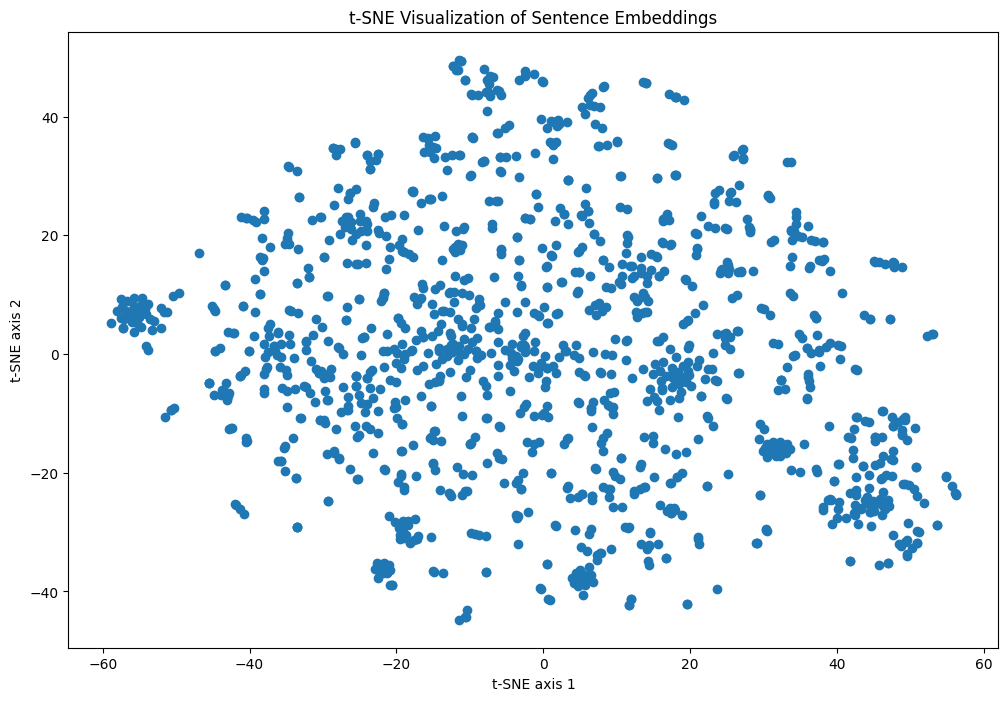

In [4]:
# Step 1: Generate Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(prompts)

# Step 2: Reduce Dimensionality with t-SNE
tsne = TSNE(n_components=2)
embeddings_reduced = tsne.fit_transform(embeddings)

# Step 3: Plotting
x_coords = embeddings_reduced[:, 0]
y_coords = embeddings_reduced[:, 1]
plt.figure(figsize=(12, 8))
plt.scatter(x_coords, y_coords)

plt.title('t-SNE Visualization of Sentence Embeddings')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.show()

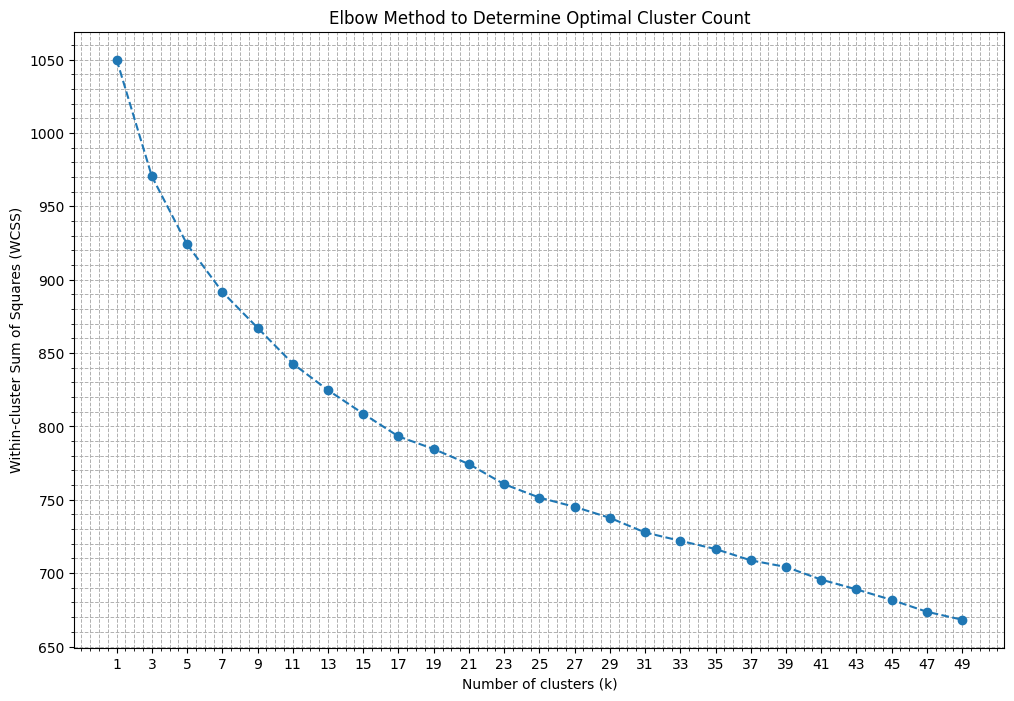

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize the list to hold the within-cluster sum of square values
wcss = []

# We might want to test a range of k values; I'll choose from 1 to 15
k_clusters = range(1, 50, 2)
for i in k_clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=0)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for that model
    if i % 10 == 0:
        print(f'Finished {i} clusters')

# Now time to craft our plot with elbow grease
plt.figure(figsize=(12, 8))
plt.plot(k_clusters, wcss, marker='o', linestyle='--')

# Let's make it look top-notch, follow the material design principles for crisp visuals
plt.title('Elbow Method to Determine Optimal Cluster Count')
plt.xlabel('Number of clusters (k)')
plt.xticks(k_clusters)
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.minorticks_on()
plt.show()

/tmp/ipykernel_19017/4054354788.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('turbo', k_optimal)  # 'tab10' provides nice distinct colors


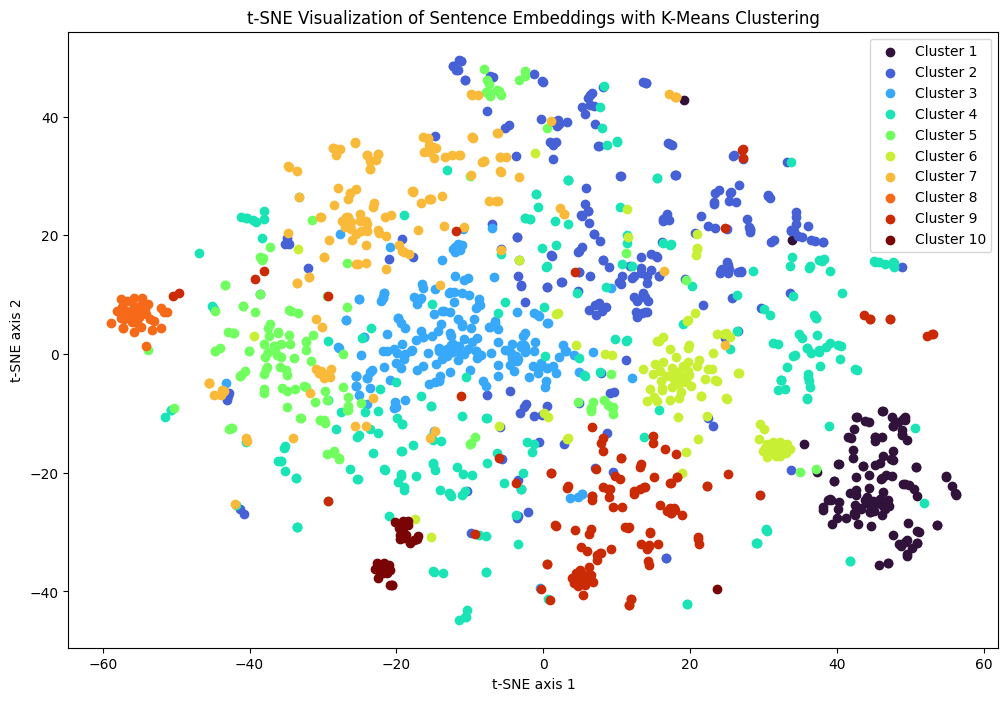

In [6]:
# Let's assume k_optimal is the optimal cluster count we selected from the elbow plot
k_optimal = 10  # Replace this with the actual optimal number of clusters you have observed

# Now run the K-Means algorithm with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans_optimal.fit_predict(embeddings)

# Then we visualize using a palette that has a nice variety of distinct colors
palette = plt.cm.get_cmap('turbo', k_optimal)  # 'tab10' provides nice distinct colors
plt.figure(figsize=(12, 8))

# Scatter plot with color coding for each cluster
for i in range(k_optimal):
    plt.scatter(x_coords[cluster_labels == i], y_coords[cluster_labels == i], label=f'Cluster {i+1}', c=[palette(i)])

# Shining the spotlight on good design – a must for great UX
plt.title('t-SNE Visualization of Sentence Embeddings with K-Means Clustering')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')

# Add that crisp legend, positioned so it doesn’t smudge our plot
plt.legend()

# And display!
plt.show()

Saving Cluster Data

In [7]:
# Make cluster to prompt map
cluster_to_prompt = {}
for i in range(k_optimal):
    cluster_to_prompt[i] = []
    for j in range(len(prompts)):
        if cluster_labels[j] == i:
            cluster_to_prompt[i].append(prompts[j])

# Save cluster to prompt map
import json
with open('cluster_to_prompt.json', 'w') as f:
    json.dump(cluster_to_prompt, f)

Making WordClouds for each cluster. Haha

Cluster 0


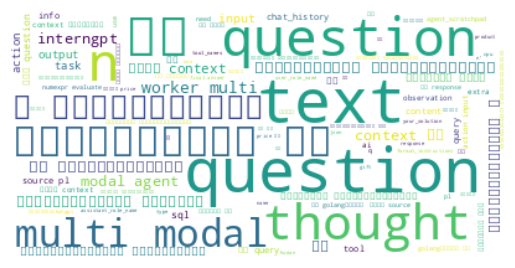

Cluster 1


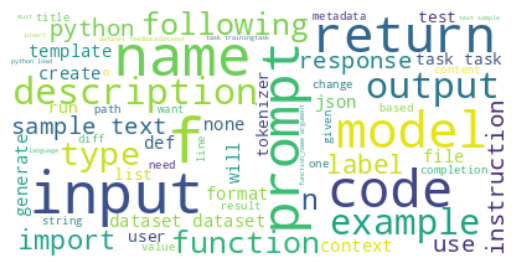

Cluster 2


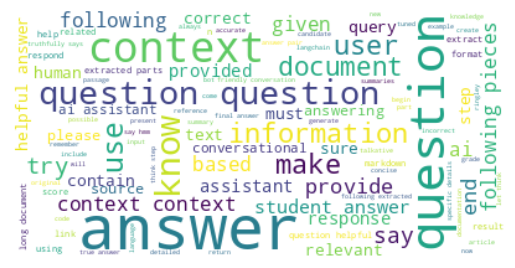

Cluster 3


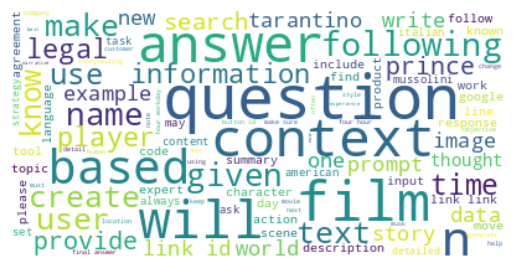

Cluster 4


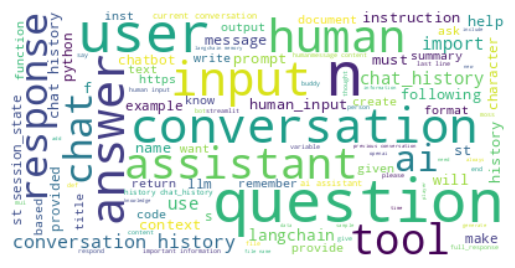

Cluster 5


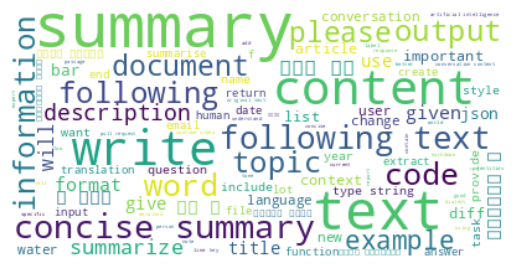

Cluster 6


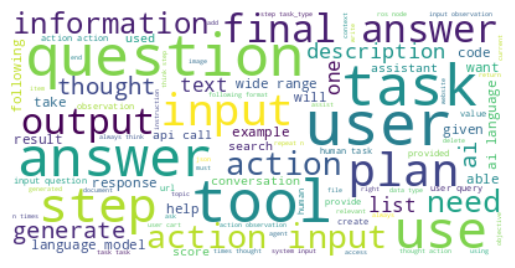

Cluster 7


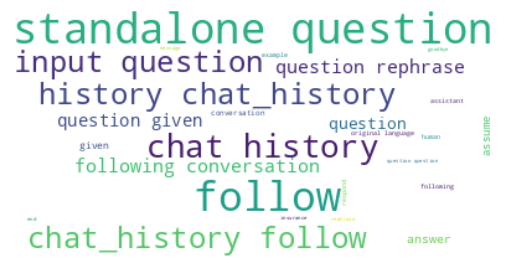

Cluster 8


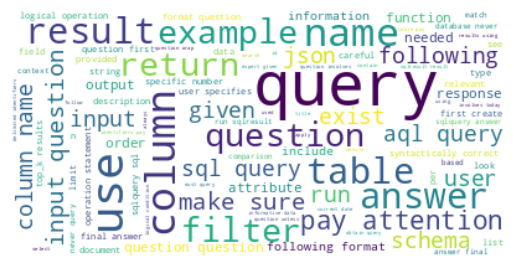

Cluster 9


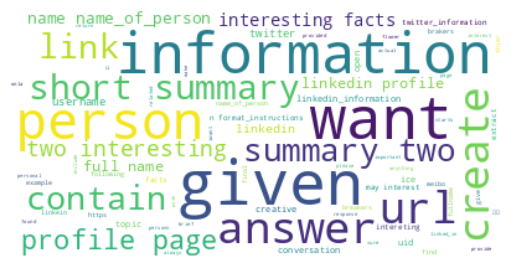

In [8]:
from wordcloud import WordCloud

def generate_wordcloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Generate wordcloud for each cluster
for i in range(k_optimal):
    print(f'Cluster {i}')
    generate_wordcloud(' '.join(cluster_to_prompt[i]).lower())

### 🗨️ Semantic Textual Similarity

In [9]:
from sentence_transformers import SentenceTransformer, util

# Download model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# The sentences we'd like to compute similarity about
sentences = all_strings
sim_scores = [0] * len(sentences)

# Get embeddings of sentences
embeddings = model.encode(sentences)

# Compute similarities (takes 30 secs to go through 1100-ish prompts)
for i in range(len(sentences)):
    for j in range(len(sentences)):
        sim_scores[i] += util.cos_sim(embeddings[i], embeddings[j]).tolist()[0][0]

    sim_scores[i] /= len(sentences)
    if i % 100 == 0:
        print(i, end=" ")
print()

# Print the results
sorted_scores = sorted(((score, sentence) for sentence, score in zip(sentences, sim_scores)), reverse=True)
for score, sentence in sorted_scores:
    print(f"{score:.4f}", end=" ")

0 100 200 300 400 500 600 700 800 900 1000 1100 
0.3386 0.3360 0.3243 0.3243 0.3224 0.3212 0.3202 0.3174 0.3174 0.3174 0.3154 0.3146 0.3145 0.3128 0.3127 0.3121 0.3121 0.3120 0.3118 0.3118 0.3118 0.3118 0.3118 0.3118 0.3118 0.3118 0.3110 0.3107 0.3095 0.3094 0.3084 0.3081 0.3079 0.3079 0.3079 0.3078 0.3073 0.3072 0.3036 0.3018 0.3017 0.3017 0.3017 0.3013 0.2997 0.2979 0.2978 0.2977 0.2974 0.2971 0.2968 0.2955 0.2946 0.2931 0.2922 0.2916 0.2911 0.2903 0.2900 0.2900 0.2900 0.2900 0.2900 0.2900 0.2900 0.2897 0.2896 0.2891 0.2891 0.2890 0.2887 0.2885 0.2883 0.2883 0.2883 0.2883 0.2883 0.2883 0.2880 0.2880 0.2880 0.2874 0.2866 0.2866 0.2864 0.2864 0.2864 0.2855 0.2853 0.2853 0.2853 0.2851 0.2851 0.2851 0.2843 0.2842 0.2842 0.2842 0.2842 0.2838 0.2836 0.2836 0.2831 0.2830 0.2830 0.2830 0.2830 0.2830 0.2829 0.2827 0.2818 0.2816 0.2812 0.2804 0.2800 0.2798 0.2792 0.2792 0.2792 0.2792 0.2792 0.2784 0.2783 0.2783 0.2783 0.2778 0.2777 0.2777 0.2775 0.2775 0.2775 0.2775 0.2775 0.2774 0.2772 0.2772

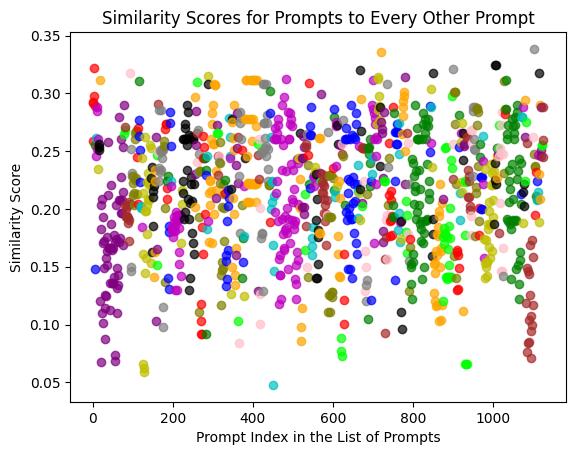

In [10]:
# Show the results visually
import matplotlib.pyplot as plt
import numpy as np

# Plot the scores
# plt.figure(figsize=(12, 8))
plt.title('Similarity Scores for Prompts to Every Other Prompt')
plt.xlabel('Prompt Index in the List of Prompts')
plt.ylabel('Similarity Score')

x_coords = np.arange(len(sentences))
y_coords = sim_scores

# Scatter plot with color mapping
for x, y, color in zip(x_coords, y_coords, color_map):
    plt.scatter(x, y, color=color, alpha=0.7)

plt.show()

### 🗨️ **Semantic Search**

In [11]:
# Queries and their embeddings
queries = ["Are you using Langchain?", "Are you using a chatbot?", "Are you an instructional or commanding prompt?"]
queries_embeddings = model.encode(queries)

# Find the top-2 corpus documents matching each query
hits = util.semantic_search(queries_embeddings, embeddings, top_k=2)

for i in range(len(queries)):
    print("\n======================\n")
    print("Query:", queries[i])

    for hit in hits[i]:
        print(sentences[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))
        print()



Query: Are you using Langchain?
"""
    You are an expert programmer and problem-solver, tasked to answer any question about Langchain. Using the provided context, answer the user's question to the best of your ability using the resources provided.
    If you really don't know the answer, just say "Hmm, I'm not sure." Don't try to make up an answer.
    Anything between the following markdown blocks is retrieved from a knowledge bank, not part of the conversation with the user. 
    <context>
        {context} 
    <context/>""" (Score: 0.4403)

"""
    You are an expert programmer and problem-solver, tasked to answer any question about Langchain. Using the provided context, answer the user's question to the best of your ability using the resources provided.
    If you really don't know the answer, just say "Hmm, I'm not sure." Don't try to make up an answer.
    Anything between the following markdown blocks is retrieved from a knowledge bank, not part of the conversation with the u

### 🗨️ **Paraphrase Mining** (Just Messing around)

In [12]:
# Look for paraphrases
paraphrases = util.paraphrase_mining(model, sentences)
print(len(paraphrases))
# Print paraphrases
for paraphrase in paraphrases[:2]:
    score, i, j = paraphrase
    print("Score {:.4f} ---- {} ---- {}\n".format(score, sentences[i], sentences[j]))

79284
Score 1.0000 ---- """The following is a conversation between an AI and a human regarding implementation of a robot software.
    
    Summarize the conversation in bullet point format by extracting the most important information exchanged within the conversation.
    
    Please include any mentioned numbers in the summary, as they are important to the conversation.

    Conversation:
    {input}""" ---- """The following is a conversation between an AI and a human regarding implementation of a robot software.

    Summarize the conversation in bullet point format by extracting the most important information exchanged within the conversation.

    Please include any mentioned numbers in the summary, as they are important to the conversation.

    Conversation:
    {input}"""

Score 1.0000 ---- """
        You are an expert in creating strategies for getting a four-hour workday. You are a productivity coach and you have helped many people achieve a four-hour workday.
        You're

### 😶‍🌫️ **Word Cloud for All Prompts**

Why? Cuz, why not? lol

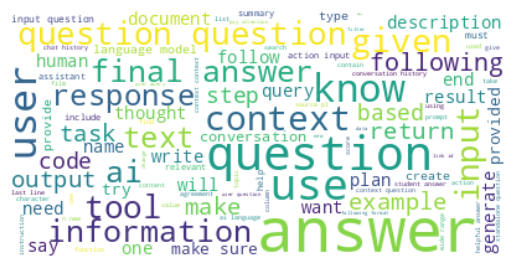

In [13]:
generate_wordcloud(' '.join(sentences).lower())